In [1]:
import os
import pdb
import math
import time
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable, Function
from tqdm import tqdm
from torch.distributions.normal import Normal
from torch.distributions.relaxed_bernoulli import RelaxedBernoulli, LogitRelaxedBernoulli
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical
from torch.distributions.categorical import Categorical

In [2]:
def Binarize(tensor,quant_mode='det'):
    # det: 确定性二值化（前向传播）
    if quant_mode=='det':
        tensor = tensor.sign()
        tensor[tensor==0] = 1  # 零值处理为+1 
        return tensor
    else:  # 随机二值化（引入噪声）
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)


def sampling(mu,sig):
    # 概率采样函数（实现不确定性量化）
    x = Normal(mu,abs(sig))
    #p = 1 - x.cdf(0)
    p = 1 - x.cdf(torch.tensor(0))
    return p


###############################
### 概率二值线性层
###############################
class PBinarizeLinear(nn.Linear):
    def __init__(self, *kargs, **kwargs):
        super(PBinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):      
        # 权重备份（用于概率裁剪）
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()  
        # 概率裁剪实现
        # 论文：防止极端权重值，确保合理梯度流 
        self.weight.data=Binarize(self.weight.org)
        theta = torch.tanh(self.weight)  # 权重映射到[-1,1]

        if input.size(1) != 784:  # 非输入层 
          mu = nn.functional.linear(input,theta)
          # 方差计算（对应论文的统计特性建模）
          left = input**2 - (1- input**2)
          right = theta**2 - (1-theta**2)
          sigma = 1 - nn.functional.linear(left,right)
        else:  # 输入层
          input = torch.tanh(input)
          mu = nn.functional.linear(input,theta)       
          sigma = nn.functional.linear(input**2,1-(theta**2))
        # PBNN核心步骤
        m = mu.mean(0,True)
        v = sigma.var(0,True)
        # 正则化
        mu = 0.5*(mu-m)/((v+(0.0001)).sqrt()+0.5)
        sigma = 0.5**2*sigma/(v+0.0001)
        # 概率采样
        out1 = sampling(mu,sigma)

        if self.out_features==10:  # 输出层直接返回均值（不采样）
          return mu
        else:
          return out1


###############################
### 概率二值卷积层
###############################
class PBinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(PBinarizeConv2d, self).__init__(*kargs, **kwargs)
        

    def forward(self, input):
        # 权重备份和概率裁剪
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()  
            
        self.weight.data=Binarize(self.weight.org)
        theta = torch.tanh(self.weight)
        
        # 特征图处理
        if input.size(1) != 1:  # 非单通道输入 
          mu = nn.functional.conv2d(input, theta, None, self.stride,
                                   self.padding, self.dilation, self.groups)
          # 方差计算（概率建模核心）
          left = input**2 - (1- input**2)
          right = theta**2 - (1-theta**2)
          sigma = 1 - nn.functional.conv2d(left, right, None, self.stride,
                                   self.padding, self.dilation, self.groups)
        else:  # 单通道输入
          input = torch.tanh(input)
          mu = nn.functional.conv2d(input, theta, None, self.stride,
                                   self.padding, self.dilation, self.groups)
          sigma = nn.functional.conv2d(input**2, 1-(theta**2), None, self.stride,
                                   self.padding, self.dilation, self.groups)

        # PBNN 核心步骤
        m = mu.mean((0,2,3),True)
        v = sigma.var((0,2,3)).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        # 正则化
        mu = 0.5*(mu-m)/((v+(0.0001)).sqrt()+0.5)
        sigma = 0.5**2*sigma/(v+0.0001)
        # MAXPOOL空间下采样（最大化信息保留）
        mu = nn.functional.max_pool2d(mu, 2, 2,0, 1, False,False)
        sigma = nn.functional.max_pool2d(sigma, 2, 2,0, 1, False,False)
        # 概率采样输出 
        out1 = sampling(mu,sigma)
   
        return out1

In [3]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)

In [4]:
# 32C3 - MP2 - 64C3 - Mp2 - 512FC - SM10c
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = PBinarizeConv2d(1, 32, kernel_size=3)
        self.mp1= nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = PBinarizeConv2d(32, 64, kernel_size=3)
        self.mp2= nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = PBinarizeLinear(1600, 512)
        self.fc2 = PBinarizeLinear(512, 10)


    # 32C3 - MP2 - 64C3 - Mp2 - 512FC - SM10c
  
    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = x.view(x.size(0), -1)
      x = self.fc1(x)
      x = self.fc2(x)
      return x
  

model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)

In [5]:
loss_history = []
acc_history = []

def train(epoch):
    model.train()
    losses = []
    trainloader = tqdm(train_loader)
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

#         if epoch%40==0: # 动态学习率
#             optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        loss.backward()
    
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-0.9,0.9))
    
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)



def test():
    model.eval()
    test_loss = 0
    correct = 0
    testloader = tqdm(test_loader)
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        with torch.no_grad():
          data = Variable(data)
        target = Variable(target)
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        loss = test_loss / len(test_loader.dataset)
        acc = (100. *correct / len(test_loader.dataset)).numpy()

        testloader.set_postfix(loss= loss,acc=str(acc)+'%')
    
    test_loss /= len(test_loader.dataset)
    total_acc = correct.item()/len(test_loader.dataset)
    loss_history.append(test_loss)
    acc_history.append(total_acc)

In [6]:
%%time
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

memory_usage_1 = torch.cuda.memory_allocated() / 1024**3
for epoch in range(10):
    train(epoch)
    test()
memory_usage_2 = torch.cuda.memory_allocated() / 1024**3
memory_usage = memory_usage_2 - memory_usage_1
print("Memory usage: {:.2f} GB".format(memory_usage))

100%|████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 50.01it/s, acc=97.9%, loss=0.000505]

Memory usage: 0.03 GB
CPU times: total: 2min 37s
Wall time: 2min 49s


In [12]:
print("Memory usage: {:.2f} MB".format(memory_usage*1024))

Memory usage: 29.12 MB


[0.0010781190890818834, 0.0007760681830346585, 0.0006693357141688466, 0.0005971903020516038, 0.0006840071419253945, 0.0005628254530020058, 0.0005865011770278216, 0.0005056997385807335, 0.00046249814676120875, 0.0005050163511186838]
[0.9585, 0.9722, 0.9729, 0.9759, 0.9727, 0.9777, 0.9781, 0.9791, 0.9815, 0.979]


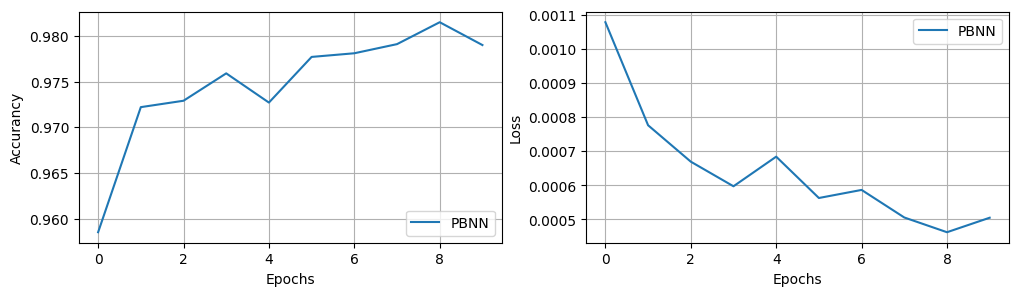

In [13]:
# 可视化代码
def visualization():
    print(loss_history)
    print(acc_history)
    
    f = plt.figure(figsize=(12,3))
    ax = f.add_subplot(121)
    ax.plot(acc_history,label='PBNN')
    ax.grid()
    ax.set_ylabel('Accurancy')
    ax.set_xlabel('Epochs')
    ax.legend(loc='lower right')
    
    ax2 = f.add_subplot(122)
    ax2.plot(loss_history,label='PBNN')
    ax2.grid()
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    ax2.legend(loc='upper right')

visualization()

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


100%|████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.39it/s, acc=91.37%, loss=0.00228]


Memory usage: 7.56 MB
[0.008365538430213927, 0.005579526644945145, 0.0046411241292953495, 0.004170694375038147, 0.003800026676058769, 0.003522447246313095, 0.0032662403658032415, 0.003143446932733059, 0.0029117258325219155, 0.002928955453634262, 0.0028526354014873504, 0.002512800480425358, 0.002750305500626564, 0.0025268974795937538, 0.002430761480331421, 0.0025017997086048127, 0.0023302387952804566, 0.002395080578327179, 0.0022832633689045907, 0.002280168890953064]
[0.6762, 0.786, 0.8255, 0.8408, 0.8503, 0.8674, 0.872, 0.8797, 0.8864, 0.8868, 0.8887, 0.9033, 0.895, 0.9035, 0.9054, 0.9047, 0.9112, 0.9093, 0.9113, 0.9137]
CPU times: total: 5min 14s
Wall time: 5min 22s


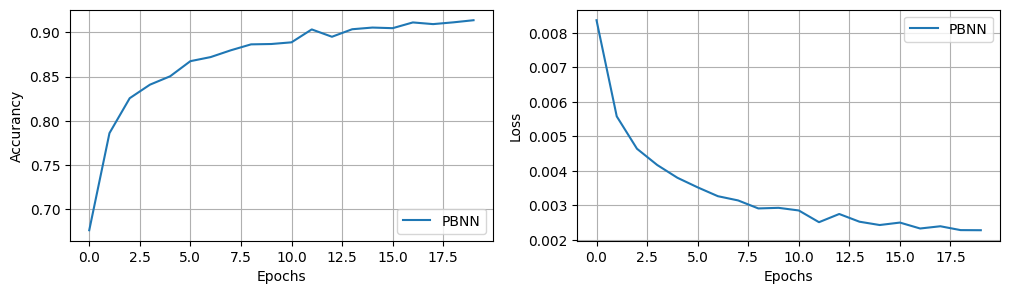

In [15]:
%%time
# 使用 SGD 优化器完成实验
# 模型初始化
loss_history = []
acc_history = []
model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(),  lr=0.01)

memory_usage_1 = torch.cuda.memory_allocated() / 1024**2
for epoch in range(20):
    train(epoch)
    test()
memory_usage_2 = torch.cuda.memory_allocated() / 1024**2
memory_usage = memory_usage_2 - memory_usage_1
print("Memory usage: {:.2f} MB".format(memory_usage))
visualization()

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


100%|████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.71it/s, acc=96.03%, loss=0.00107]


Memory usage: 10.54 MB
[0.003110981547832489, 0.0024510416969656945, 0.002050608842074871, 0.0019279503270983695, 0.0018195676431059836, 0.00168137094527483, 0.001632205454260111, 0.0016428625002503396, 0.001470528531074524, 0.0015958186849951744, 0.001444632352143526, 0.0014102846898138522, 0.0013960407964885234, 0.0012725743129849434, 0.0013403744600713253, 0.0012843627788126468, 0.0013799107845872641, 0.0012226601544767619, 0.001199319875985384, 0.0010710677608847619]
[0.8798, 0.9043, 0.9222, 0.9257, 0.9316, 0.9335, 0.9363, 0.94, 0.944, 0.9411, 0.9451, 0.9459, 0.946, 0.9522, 0.9475, 0.95, 0.9454, 0.9526, 0.9529, 0.9603]
CPU times: total: 5min 23s
Wall time: 5min 32s


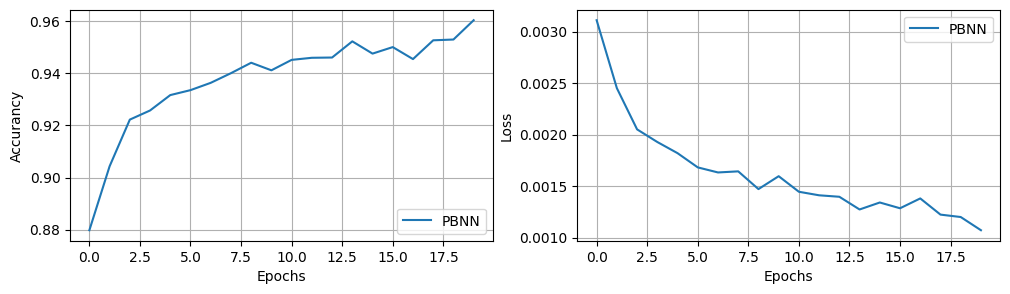

In [16]:
%%time
# 使用 SGD + 动量法优化器完成实验
# 模型初始化
loss_history = []
acc_history = []
model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01)
#optimizer = optim.SGD(model.parameters(),  lr=0.01)
optimizer = optim.SGD(model.parameters(),  lr=0.01, momentum=0.9)  # 修改点：添加动量参数 

memory_usage_1 = torch.cuda.memory_allocated() / 1024**2
for epoch in range(20):
    train(epoch)
    test()
memory_usage_2 = torch.cuda.memory_allocated() / 1024**2
memory_usage = memory_usage_2 - memory_usage_1
print("Memory usage: {:.2f} MB".format(memory_usage))
visualization()

以上为pytorch神经网络的训练代码，下面在模型中分别引入如下的噪声，以完成鲁棒性检验：

N()0,si'g'maσ2@^，， si'g'maσshu'yu∈[]0, 0.5Ppshu'yu∈[]0,0.4 Qqshu'yu∈[]0，， 0.3p%0%e'p'spsilonε~Ber'nou'linou()q

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


100%|███████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.07it/s, acc=97.59%, loss=0.000633]


[0.0012653059016913175, 0.0009743288923054934, 0.0008040683997794986, 0.0008173399347811937, 0.0008375195223838091, 0.0008910715829581023, 0.0007308809055015445, 0.0007296303428709507, 0.0005952951986342668, 0.0005611857727169991, 0.0007890855450183153, 0.0005044960128609091, 0.0006291417967528105, 0.0006262494571506977, 0.0005696194757707418, 0.0005501666598021984, 0.000534351688832976, 0.000540503597073257, 0.0005548059199936688, 0.0006326502644456923]
[0.9517, 0.9627, 0.9677, 0.9677, 0.9662, 0.9634, 0.9707, 0.9721, 0.9756, 0.9773, 0.968, 0.9798, 0.9757, 0.9752, 0.9774, 0.9781, 0.9794, 0.9791, 0.978, 0.9759]
CPU times: total: 5min 44s
Wall time: 5min 55s


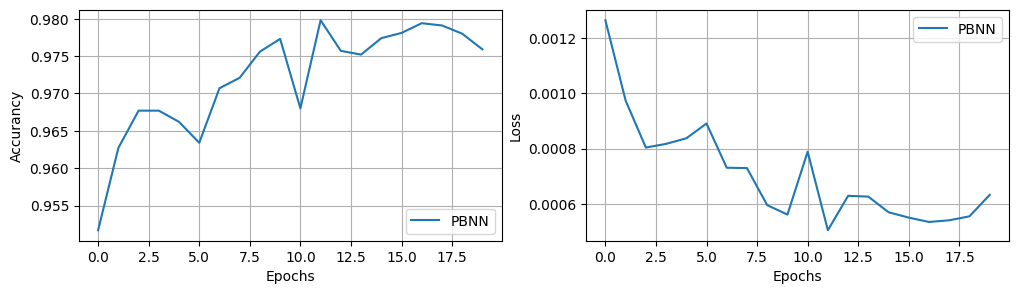

In [17]:
%%time
# 高斯噪声 sigma = 0.1
class AddGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0., std=0.1):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std

gaussian_noise = AddGaussianNoise(std=0.1)  # 控制σ∈[0, 0.5]
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       gaussian_noise  # 添加高斯噪声
                   ])),
    batch_size=128, shuffle=True)

# 模型初始化
loss_history = []
acc_history = []
model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    train(epoch)
    test()

# 可视化
visualization()

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


100%|███████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.77it/s, acc=97.16%, loss=0.000665]


[0.0015342330366373061, 0.0012449002370238304, 0.0010990218008402736, 0.0009595312364399433, 0.0009000924801453948, 0.0010123760387301445, 0.0009784015074372292, 0.0008769284252077341, 0.0009275736670941114, 0.0008063793336972595, 0.0006868303883820772, 0.0007416571067646146, 0.0007254638401791453, 0.0007579658137634396, 0.0007529161407612264, 0.0007260148333385587, 0.000792576964572072, 0.0006755176896229387, 0.0006514348402619362, 0.000665332607831806]
[0.9408, 0.9506, 0.9562, 0.9621, 0.9657, 0.9609, 0.9625, 0.9667, 0.9623, 0.967, 0.9716, 0.9719, 0.9729, 0.9711, 0.9701, 0.9737, 0.969, 0.9727, 0.9745, 0.9716]
CPU times: total: 5min 58s
Wall time: 6min 11s


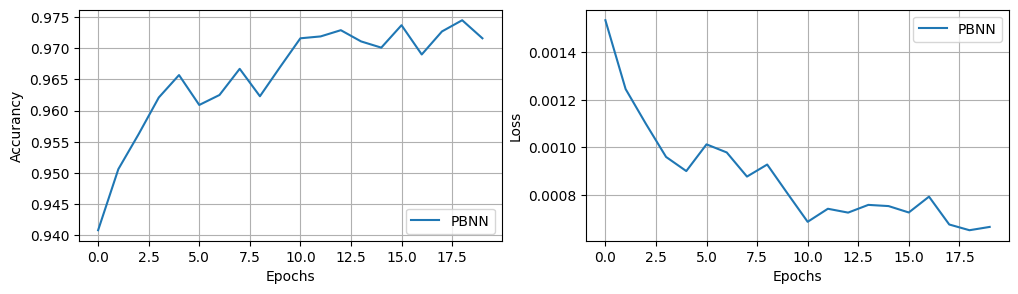

In [18]:
%%time
# 高斯噪声 sigma = 0.5
gaussian_noise = AddGaussianNoise(std=0.5)  # 控制σ∈[0, 0.5]
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       gaussian_noise  # 添加高斯噪声
                   ])),
    batch_size=128, shuffle=True)

# 模型初始化
loss_history = []
acc_history = []
model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()

# 可视化
visualization()

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


100%|███████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.48it/s, acc=97.95%, loss=0.000525]


[0.0009278698369860649, 0.0008591829372569919, 0.0007208947306498885, 0.0005816354949958623, 0.0006227010017260909, 0.0005731012614443898, 0.0005216371636372059, 0.00047467659714166076, 0.0005072869380936027, 0.0004619622530415654, 0.0005675000066868961, 0.0005099714729934931, 0.0005405877675977535, 0.00047296252842061223, 0.0005023004971910269, 0.00046320745376870033, 0.0004572586227877764, 0.00043642055774107574, 0.00041977153103798625, 0.0005251252576708794]
[0.9646, 0.966, 0.9733, 0.9762, 0.9759, 0.9773, 0.9797, 0.9797, 0.9811, 0.9824, 0.9788, 0.9798, 0.9787, 0.981, 0.9803, 0.9816, 0.9823, 0.9835, 0.984, 0.9795]
CPU times: total: 5min 28s
Wall time: 5min 38s


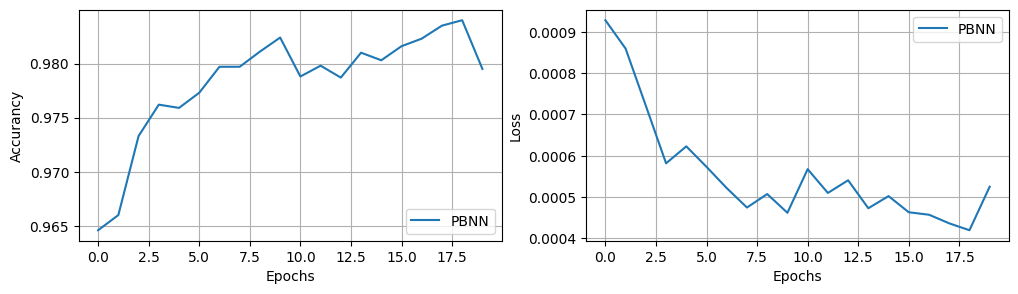

In [19]:
%%time
# 训练标签噪声，noise_level = 0.1
def add_label_noise(labels, noise_level=0.1):  # p∈[0, 40%]
    num_noisy = int(noise_level * len(labels))
    indices = torch.randperm(len(labels))[:num_noisy]
    noisy_labels = labels.clone()
    noisy_labels[indices] = torch.randint(0, 10, (num_noisy,))
    return noisy_labels

# 加载数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
# 翻转部分标签
for batch_idx, (data, target) in enumerate(train_loader):
    target = add_label_noise(target, noise_level=0.1)


# 模型初始化
loss_history = []
acc_history = []
model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()
# 可视化
visualization()

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


100%|███████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.58it/s, acc=97.99%, loss=0.000532]


[0.0010957260634750128, 0.0007723209951072932, 0.0007147745492635295, 0.0005894535583443939, 0.0005946961211040616, 0.0005308826944557949, 0.0005464133691973984, 0.0004712588436901569, 0.0005134508421644568, 0.0005457195204682648, 0.0004665044262073934, 0.0004962134543457068, 0.000555073481798172, 0.0005158620952628553, 0.00044956734362058343, 0.0004517462078249082, 0.0005563375366851687, 0.0005043494438752532, 0.00045024685775861144, 0.0005315436403732747]
[0.9592, 0.973, 0.9705, 0.9742, 0.9762, 0.9779, 0.9776, 0.9819, 0.9788, 0.9797, 0.9804, 0.9806, 0.9784, 0.9794, 0.9823, 0.9821, 0.9781, 0.9813, 0.9821, 0.9799]
CPU times: total: 5min 32s
Wall time: 5min 43s


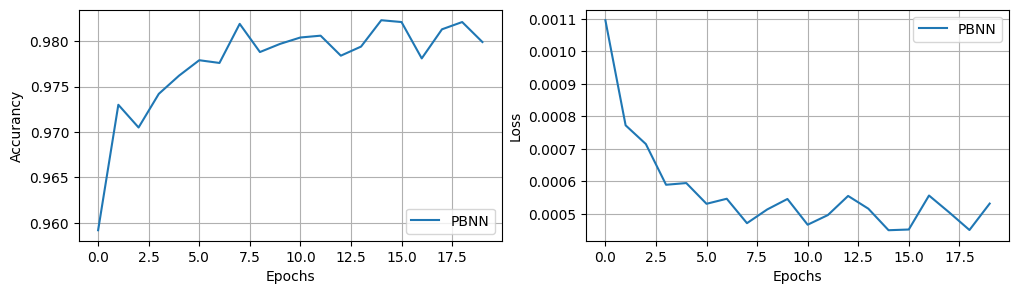

In [20]:
%%time
# 训练标签噪声，noise_level = 0.4
# 加载数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
# 翻转部分标签
for batch_idx, (data, target) in enumerate(train_loader):
    target = add_label_noise(target, noise_level=0.4)

# 模型初始化
loss_history = []
acc_history = []
model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()
# 可视化
visualization()

Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


100%|█████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.67it/s, acc=55.84%, loss=0.0109]


[0.011237433493137359, 0.011145885944366454, 0.010602333623170852, 0.011176544797420501, 0.010840090203285217, 0.010739796149730682, 0.011347824728488921, 0.010885414671897888, 0.01071958909034729, 0.011008073103427886, 0.010652895164489746, 0.010922084641456603, 0.010695856511592865, 0.011218134653568268, 0.010943722265958786, 0.010930290639400483, 0.01129343295097351, 0.011188042628765106, 0.010918867945671082, 0.010851444417238235]
[0.5253, 0.5373, 0.5705, 0.542, 0.5488, 0.5602, 0.5265, 0.5517, 0.566, 0.5452, 0.5782, 0.548, 0.5649, 0.5358, 0.5559, 0.5566, 0.5291, 0.5385, 0.5557, 0.5584]


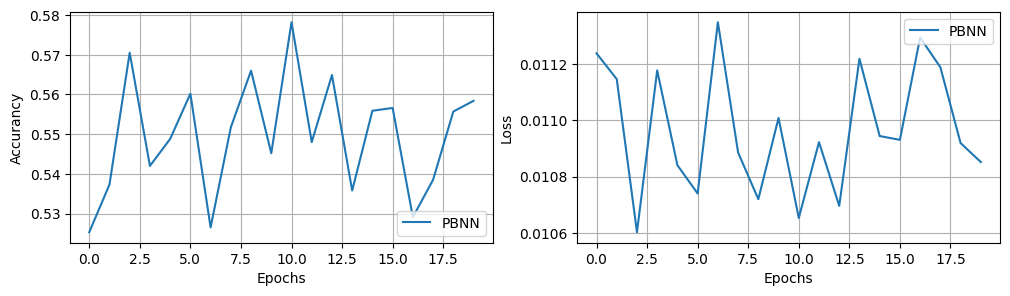

In [21]:
# 激活函数噪声 (q=0.1)
def apply_activation_noise(tensor, q=0.1):  # q∈[0, 0.3]
    noise_mask = torch.bernoulli(torch.full_like(tensor, q))
    return tensor * noise_mask

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = PBinarizeConv2d(1, 32, kernel_size=3)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = PBinarizeConv2d(32, 64, kernel_size=3)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = PBinarizeLinear(1600, 512)
        self.fc2 = PBinarizeLinear(512, 10)
    def forward(self, x):
        x = apply_activation_noise(self.conv1(x))
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = apply_activation_noise(self.fc1(x), q=0.1)  # 在全连接层施加噪声
        x = self.fc2(x)
        return x



# 加载数据
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)


# 模型初始化
loss_history = []
acc_history = []
model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()
# 可视化
visualization()

In [ ]:
# 激活函数噪声 (q=0.3)
def apply_activation_noise(tensor, q=0.3):  # q∈[0, 0.3]
    noise_mask = torch.bernoulli(torch.full_like(tensor, q))
    return tensor * noise_mask

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = PBinarizeConv2d(1, 32, kernel_size=3)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = PBinarizeConv2d(32, 64, kernel_size=3)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = PBinarizeLinear(1600, 512)
        self.fc2 = PBinarizeLinear(512, 10)
    def forward(self, x):
        x = apply_activation_noise(self.conv1(x), q=0.3)  # 在卷积层施加噪声
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = apply_activation_noise(self.fc1(x), q=0.3)  # 在全连接层施加噪声
        x = self.fc2(x)
        return x

# 模型初始化
loss_history = []
acc_history = []
model = Net()
print(model)
torch.cuda.device('cuda')
model.cuda()
# 训练
loss_history = []
acc_history = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    train(epoch)
    test()
# 可视化
visualization()